In [2]:
#Import Normal Python AI Trainng and Image stuff
import os
import PIL
import PIL.Image
import pathlib
import math
import IPython
from ipywidgets import IntProgress

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import time
import random

In [3]:
#Import Local PY Files
import Models

In [4]:
from keras.preprocessing.image import ImageDataGenerator
#To Disable GPU Accelrate uncomment the below
#tf.config.set_visible_devices([], 'GPU')

In [5]:
#General Constants that can be changed, the main thing I tweak thease is to allow for training on my meager 10GB of VRAM 
batchSize = 64
imgRawMinSize = 40
imgSize = 64
testP = 0.15
permutationsPerImage = 4

In [6]:
#Set up folder paths
imageFolder = pathlib.Path().cwd().parent.joinpath("Preprocessing/Font Images/")
imageFilePaths = list(imageFolder.glob('*.png'))
trainingProcessFoldername = "intermediateResults"
pathlib.Path(trainingProcessFoldername).mkdir(exist_ok=True)

#Set up some counts
imgCount = len(imageFilePaths) * permutationsPerImage
trainAmount = math.floor(imgCount * (1-testP))
testAmount = math.floor(imgCount * testP) + 1

#It should be noted thease numbers are the maximum possible, as some images can and will be rejected
print(imgCount)
print(trainAmount)
print(testAmount)

367760
312596
55165


In [7]:
datasetTrain = np.ndarray(shape=(imgCount, imgSize, imgSize,1),
                     dtype=np.float32)

In [8]:
def add_margin(pil_img, top, right, bottom, left):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = PIL.Image.new(pil_img.mode, (new_width, new_height), (255,255,255))
    result.paste(pil_img, (left, top))
    return result

def resize_with_padding(img,desiredSize):
    width, height = img.size

    if width > desiredSize or height > desiredSize:
        return None
    
    widthPadding = desiredSize - width
    heightPadding = desiredSize - height

    if widthPadding < 0:
        widthPadding = 0

    if heightPadding < 0:
        heightPadding = 0

    heightPadding = math.floor(heightPadding / 2)
    widthPadding = math.floor(widthPadding / 2)
    
    return add_margin(img,heightPadding,widthPadding,heightPadding,widthPadding)

In [9]:
# Currently I regenerate the full training set and hold it in memory
# Should probobly cache these results somewhere, but since Im constantly changing how I load/preprocess my data I'll take the 
# Two min time pentantly and few GB it requires per training session

index = 0
failedImages = 0
progressBar = IntProgress(min=0,max=imgCount)
IPython.display.display(progressBar)
updateStep = 100
updateCurrent = 0
for imagePath in imageFilePaths:
    testImage = PIL.Image.open(str(imagePath))
    testImage = resize_with_padding(testImage,110)

    updateCurrent += permutationsPerImage
    if updateCurrent > updateStep:
        progressBar.value += updateCurrent
        updateCurrent = 0
    
    if testImage is not None:

        testImage = testImage.resize((imgSize,imgSize)).convert("L")
        npArr = np.array(testImage)
        npArr = npArr.astype(np.float32)

        img_avg =  np.average(npArr)

        #Some images contain just black or white, this is generally considered bad data so skip it
        if img_avg < 10 or img_avg > 240:
            failedImages += permutationsPerImage
            continue

        #This inst a great way to do it, but when loading bigger and bigger data sets GPU Memory will start to run out when training
        #To fix this issue.... I do less data augmentation, which isnt a terrible thing as it means I have more unique data to train on

        #Augment the data by flipping/rotating to create more testing data
        npArr = npArr.reshape((imgSize,imgSize,1))/255
        
        npArrA = np.array(testImage.transpose(PIL.Image.FLIP_LEFT_RIGHT))
        npArrA = npArrA.astype(np.float32)
        npArrA = npArrA.reshape((imgSize,imgSize,1))/255
    
        npArrB = np.array(testImage.transpose(PIL.Image.FLIP_TOP_BOTTOM))
        npArrB = npArrB.astype(np.float32)
        npArrB = npArrB.reshape((imgSize,imgSize,1))/255
        
        npArrC = np.array(testImage.transpose(PIL.Image.ROTATE_270))
        npArrC = npArrC.astype(np.float32)
        npArrC = npArrC.reshape((imgSize,imgSize,1))/255

        #npArrD = np.array(testImage.transpose(PIL.Image.ROTATE_90))
        #npArrD = npArrD.astype(np.float32)
        #npArrD = npArrD.reshape((imgSize,imgSize,1))/255

        #npArrE = np.array(testImage.transpose(PIL.Image.ROTATE_180))
        #npArrE = npArrE.astype(np.float32)
        #npArrE = npArrE.reshape((imgSize,imgSize,1))/255
        
        datasetTrain[index] = npArr
        datasetTrain[index+1] = npArrA
        datasetTrain[index+2] = npArrB
        datasetTrain[index+3] = npArrC
        #datasetTrain[index+4] = npArrD
        #datasetTrain[index+5] = npArrE
        
    
        index += permutationsPerImage
    else:
        failedImages += permutationsPerImage

print("Rejected : " + str(failedImages))
print("Accepted : " + str(imgCount-failedImages))
imgCount = imgCount - failedImages

IntProgress(value=0, max=367760)

Rejected : 94512
Accepted : 273248


In [10]:
## Copy paste from https://www.tensorflow.org/tutorials/generative/cvae time!

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.8 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)
    
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
epochs = 60

latent_dim = 256
num_examples_to_generate = 25

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = Models.CVAE(latent_dim,imgSize)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 1)         10        
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 1)        4         
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 1)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60, 60, 32)        0

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(5, 5))
  nPredictions = predictions.numpy() * 255
  nPredictions = nPredictions.astype(np.uint8)
  nPredictions[nPredictions < 127] = 0
  nPredictions[nPredictions > 127] = 255    
  for i in range(nPredictions.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow(nPredictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig(trainingProcessFoldername + "/image_at_epoch_{:04d}.png".format(epoch))
  plt.show()

In [14]:
full_dataset = tf.data.Dataset.from_tensor_slices(datasetTrain).take(imgCount).shuffle(imgCount).batch(batchSize)
full_len = len(full_dataset)
train_dataset = full_dataset.take(math.floor(full_len * 0.8))
test_dataset = full_dataset.skip(math.floor(full_len * 0.8))

print(str(len(test_dataset)))


854


In [15]:
# Pick a sample of the test set for generating output images
print(batchSize)
print(num_examples_to_generate)
assert batchSize >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

64
25


Epoch: 60, Test set ELBO: -556.1630859375, time elapse for current epoch: 67.29700183868408


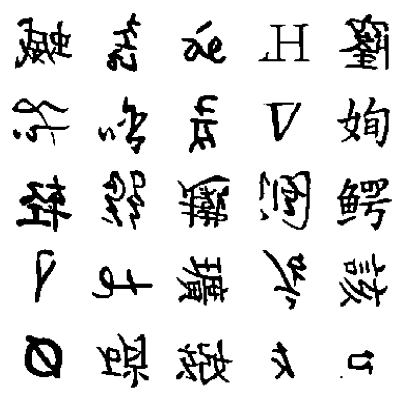

In [16]:
generate_and_save_images(model, 0, test_sample)
lossTraining = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  lossTraining.append(-elbo)
  IPython.display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


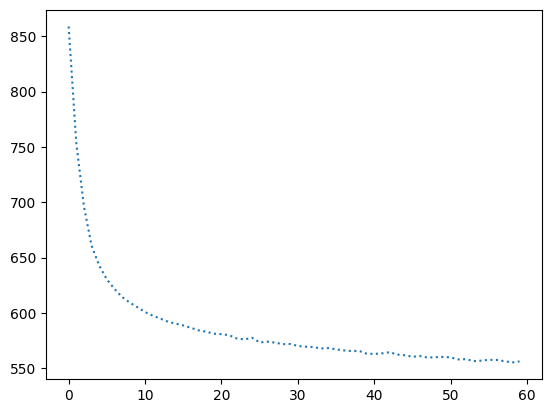

In [17]:
plt.plot(lossTraining, linestyle = 'dotted')
plt.show()

In [18]:
checkpoint_path = "checkpoints/cp-decode-base2.ckpt"
model.decoder.save_weights(checkpoint_path)

In [19]:
checkpoint_path = "checkpoints/cp-encoder-base2.ckpt"
model.encoder.save_weights(checkpoint_path)

In [20]:
def postProcessesImage(img):

  #img = img.resize((math.floor(imgSize/2),math.floor(imgSize/2)),resample=PIL.Image.BILINEAR)

  #img = img.filter(PIL.ImageFilter.MedianFilter(size=3))

  #img = img.resize((imgSize,imgSize),resample=PIL.Image.LANCZOS)  
    #img = img.point( lambda p: 255 if p > 100 else 0 )
    #img = img.filter(PIL.ImageFilter.MedianFilter(size=3))
    img = img.resize((imgSize*4,imgSize*4),resample=PIL.Image.NEAREST)
  
    for passes in range(10):
        img = img.filter(PIL.ImageFilter.MedianFilter(size=3))  
    
    #img = img.resize((imgSize,imgSize),resample=PIL.Image.LANCZOS)

    img = img.point( lambda p: 255 if p > 150 else 0 )
    
    return img

In [21]:
def display_glyphs(model, random_latent_space,imgNum):
  predictions = model.sample(random_latent_space)
  fig = plt.figure(figsize=(5, 5))
  nPredictions = predictions.numpy() * 255
  nPredictions = nPredictions.astype(np.uint8)
  for i in range(nPredictions.shape[0]):
    imgData = nPredictions[i, :, :, 0]
    (imgData-np.min(imgData))/(np.max(imgData)-np.min(imgData)) 
    img = PIL.Image.fromarray(imgData)

    img = postProcessesImage(img)
      
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  #plt.savefig('modelSampleImages/image{:04d}.png'.format(imgNum))
  plt.show()

In [22]:
def generate_rand_num(amount,numRange):
    rndNums = np.ndarray(shape=(amount))
    for i in range(amount):
        rndNums[i] = random.uniform(-numRange, numRange)
    return rndNums

In [23]:
def creatRandom2DVecInSpace(latent_dim):
    emtpyVec = np.ndarray(shape=(latent_dim))
    for i in range(latent_dim):
        emtpyVec[i] = random.randint(-1,1); 
    
    return emtpyVec

In [24]:
knownMean, knownLogvar = model.encode(datasetTrain[141654:141655, :, :, :])
knownZ = model.reparameterize(knownMean, knownLogvar)
knownGlyph = knownZ

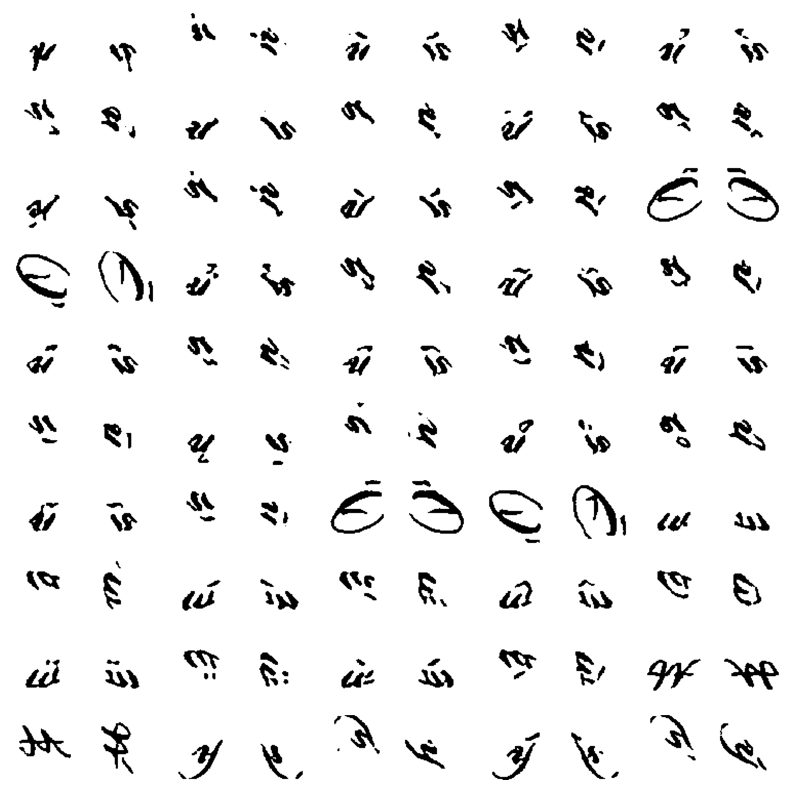

In [25]:
newGlyph = np.ndarray(shape=(100, latent_dim),
                     dtype=np.float32)

knownMean, knownLogvar = model.encode(datasetTrain[1100:1200, :, :, :])
knownZ = model.reparameterize(knownMean, knownLogvar)
newGlyph = knownZ

predictions = model.sample(knownZ)
fig = plt.figure(figsize=(10, 10))
nPredictions = predictions.numpy() * 255
nPredictions = nPredictions.astype(np.uint8)
for i in range(nPredictions.shape[0]):
    imgData = nPredictions[i, :, :, 0]
    (imgData-np.min(imgData))/(np.max(imgData)-np.min(imgData)) 
    img = PIL.Image.fromarray(imgData)
    img = postProcessesImage(img)
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  #plt.savefig('modelSampleImages/image{:04d}.png'.format(imgNum))
plt.show()

In [48]:
newGlyph = np.ndarray(shape=(25, latent_dim),
                     dtype=np.float32)
movementVec = creatRandom2DVecInSpace(latent_dim)
for i in range(25):
        newGlyph[i] = knownGlyph + 2 * (movementVec * i * 1/25)

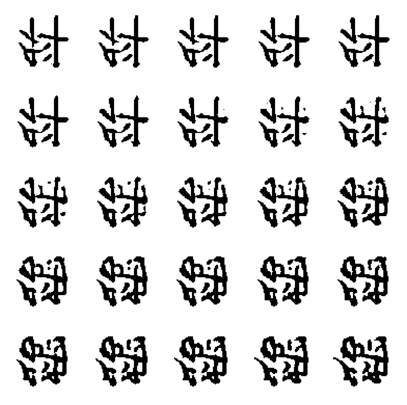

In [49]:
for samplesToGen in range(1):
    display_glyphs(model,newGlyph,samplesToGen)

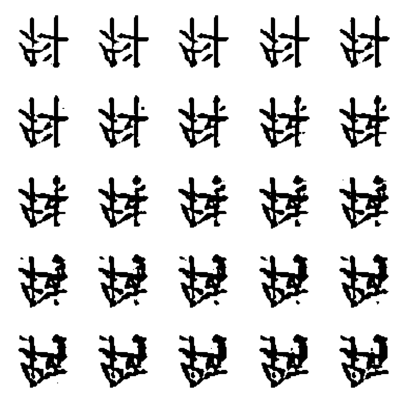

In [28]:
for samplesToGen in range(1):
    display_glyphs(model,newGlyph,samplesToGen)

In [29]:
def creatSingleRandom2DVecInSpace(latent_dim,randomRange):
    emtpyVec = np.ndarray(shape=(latent_dim))
    for i in range(latent_dim):
        emtpyVec[i] = random.gauss(mu=0.0, sigma=randomRange)
    
    return emtpyVec

In [38]:
def createRandomSet(plotSize,latent_dim,randomRange):
    plotSizeSquare = plotSize * plotSize
    #Create space for our random latent space dims
    latentSpaceGlyhs = np.ndarray(shape=(plotSizeSquare, latent_dim), dtype=np.float32)

    #Fill out our vector
    for i in range(plotSizeSquare):
        latentSpaceGlyhs[i] = creatSingleRandom2DVecInSpace(latent_dim,randomRange)
    
    predictions = model.sample(latentSpaceGlyhs)
    fig = plt.figure(figsize=(plotSize, plotSize))
    nPredictions = predictions.numpy() * 255
    nPredictions = nPredictions.astype(np.uint8)
    for i in range(nPredictions.shape[0]):
        imgData = nPredictions[i, :, :, 0]
        (imgData-np.min(imgData))/(np.max(imgData)-np.min(imgData)) 
        img = PIL.Image.fromarray(imgData)
        img = postProcessesImage(img)
        plt.subplot(plotSize, plotSize, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    #plt.savefig('modelSampleImages/image{:04d}.png'.format(imgNum))
    plt.show()



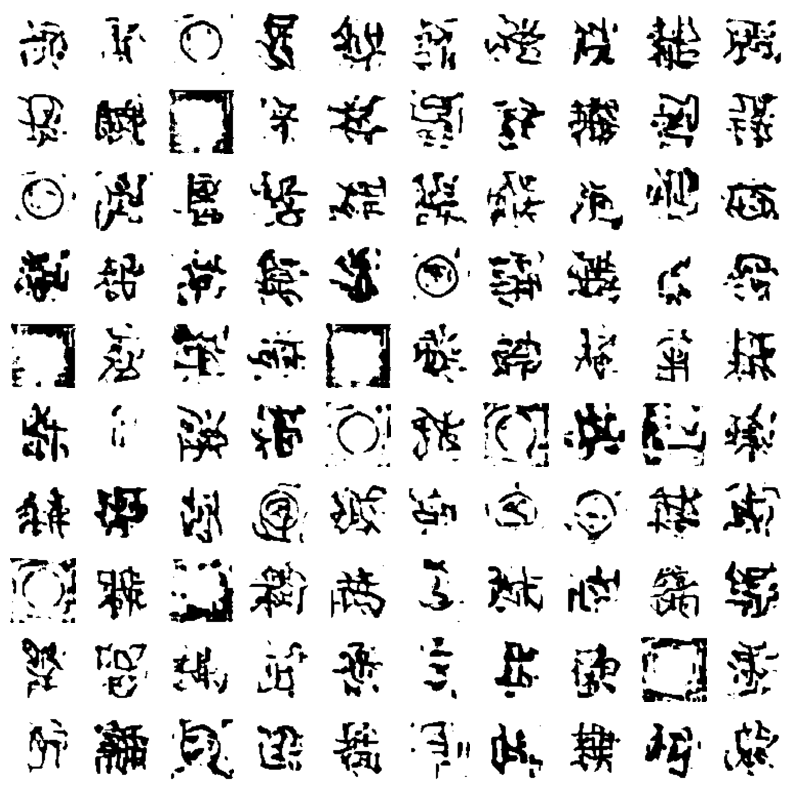

In [53]:
createRandomSet(10,latent_dim,2)